# Notebook's content

We have divided this notebook into following parts:
1. Getting your environment ready (a.k.a. loading data and packages)
2. Dataset&dataloader for the original competition data (`siim-covid19-detection`)
3. Basic data augmentation
4. Dataset&dataloader for the preprocessed competition data (`siimcovid19-512-img-png-600-study-png/study`)

# Getting ready

In [1]:
%%bash
conda install -c conda-forge gdcm -y

Solving environment: ...working... done

## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - gdcm


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2021.5.30  |       ha878542_0         136 KB  conda-forge
    certifi-2021.5.30          |   py37h89c1867_0         141 KB  conda-forge
    gdcm-2.8.9                 |   py37h5d359c0_2         3.4 MB  conda-forge
    libjpeg-turbo-2.1.0        |       h7f98852_0         987 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         4.7 MB

The following NEW packages will be INSTALLED:

  gdcm               conda-forge/linux-64::gdcm-2.8.9-py37h5d359c0_2
  libjpeg-turbo      conda-forge/linux-64::libjpeg-turbo-2.1.0-h7f98852_0

The following packages will be UPDATED:

  ca-certificates                      2020.12

In [2]:
import cv2
import io
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from PIL import Image
import pydicom
import seaborn as sns
import warnings

In [3]:
TRAIN_DIR = '../input/siim-covid19-detection/train'
TEST_DIR = '../input/siim-covid19-detection/test'

In [4]:
train = pd.read_csv('../input/siim-covid19-detection/train_image_level.csv')
train_study = pd.read_csv('../input/siim-covid19-detection/train_study_level.csv')
train_study.head()

,id,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance
0,00086460a852_study,0,1,0,0
1,000c9c05fd14_study,0,0,0,1
2,00292f8c37bd_study,1,0,0,0
3,005057b3f880_study,1,0,0,0
4,0051d9b12e72_study,0,0,0,1


In [5]:
train_study['id'] = train_study['id'].apply(lambda i: i.split('_')[0])
train_study.rename(columns={'Negative for Pneumonia': '0','Typical Appearance': '1',"Indeterminate Appearance": '2',
                   "Atypical Appearance": "3"}, inplace=True)
train_study.head()

,id,0,1,2,3
0,00086460a852,0,1,0,0
1,000c9c05fd14,0,0,0,1
2,00292f8c37bd,1,0,0,0
3,005057b3f880,1,0,0,0
4,0051d9b12e72,0,0,0,1


In [6]:
labels = []
def get_label(row):
    for c in train_study.columns:
        if row[c] == 1:
            labels.append(int(c))
            
train_study.apply(get_label, axis=1)
train_study.drop(columns=['0', '1','2', '3'], inplace=True)
train_study['label'] = labels
train_study.head()

,id,label
0,00086460a852,1
1,000c9c05fd14,3
2,00292f8c37bd,0
3,005057b3f880,0
4,0051d9b12e72,3


# Do I need a dataloader?

If you are planning to use `pytorch` package, then answer is simply **yes**, you do! Dataloader is a simple data iterator, increasing clarity of your code and providing an easy way to split dataset into batches. Dataloader wraps around a Dataset object - a way to tell your computer, how to find your data. You can find more details in this official pytorch tutorial -> [link](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html)

### Dataloader for original competition data

Spoiler alert! in the following code we:
1. extract image path from previously loaded dataframe
2. extract image data from the dcm object
3. resize images
4. do data augmentations (explenations in the next part of this notebook)
5. return a image-label pair

In [7]:
from os import listdir, walk
from skimage import exposure
import torch
from torch.utils.data import Dataset, DataLoader

In [8]:
class CovLungDataset(Dataset):
    def __init__(self, dir_path, labels_data, transforms=None, new_size=(512, 512)):
        self.dir_path = dir_path
        self.labels_data = labels_data
        self.new_size = new_size
        self.transforms = transforms

    def __len__(self):
        return len(self.labels_data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        image_dir = self.labels_data.iloc[idx]['id']
        img_label = self.labels_data.iloc[idx]['label']
        
        path_to_img = os.path.join(self.dir_path, image_dir)
        # get first image path only
        path_to_img = os.path.join(path_to_img, listdir(path_to_img)[0])
        path_to_img = os.path.join(path_to_img, next(walk(path_to_img))[2][0])
        
        # read image
        data = pydicom.dcmread(path_to_img)
        image = data.pixel_array
        image = exposure.equalize_hist(image)
        
        good_height, good_width = self.new_size
        image = cv2.resize(image, (good_width, good_height), interpolation=Image.LANCZOS)
        
        # data augmentation
        if self.transforms:
            # doesn't work on floats
            image = (image * 255).astype(np.uint8)
            image = self.transforms(image=image)['image']
        
        sample = {'image': image, 'label': img_label}
        return sample

# Should I do data augmentation?

Probably **yes**, unless you're not afraid of overfitting.

According to [Wikipedia](https://en.wikipedia.org/wiki/Data_augmentation):
> Data augmentation in data analysis are techniques used to increase the amount of data by adding slightly modified copies of already existing data or newly created synthetic data from existing data. It acts as a regularizer and helps reduce overfitting when training a machine learning model.

In this tutorial, we will experiment with brightness and rotation of the images, but be aware that you can do much more.

In [9]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

transform = A.Compose([A.RandomBrightnessContrast(brightness_limit=[-0.2, 0.2], 
                                                  contrast_limit=[-0.2, 0.2], 
                                                  p=0.5),
                       A.ShiftScaleRotate(scale_limit=[-0.1, 0.3], 
                                          shift_limit=0.1, 
                                          rotate_limit=20, 
                                          border_mode=cv2.BORDER_CONSTANT,
                                          p=0.5),
                       # reshape image of size (k, n, 1) into (1, k, n)
                       ToTensorV2(p=1.0)
                      ])

Let's combine that with our dataloader and check the results.

In [10]:
transformed_dataset = CovLungDataset(dir_path=TRAIN_DIR,
                                     labels_data=train_study[['id', 'label']],
                                     transforms=transform,
                                     new_size=(512, 512))


train_dataloader = DataLoader(transformed_dataset, batch_size=8, shuffle=False, num_workers=2)

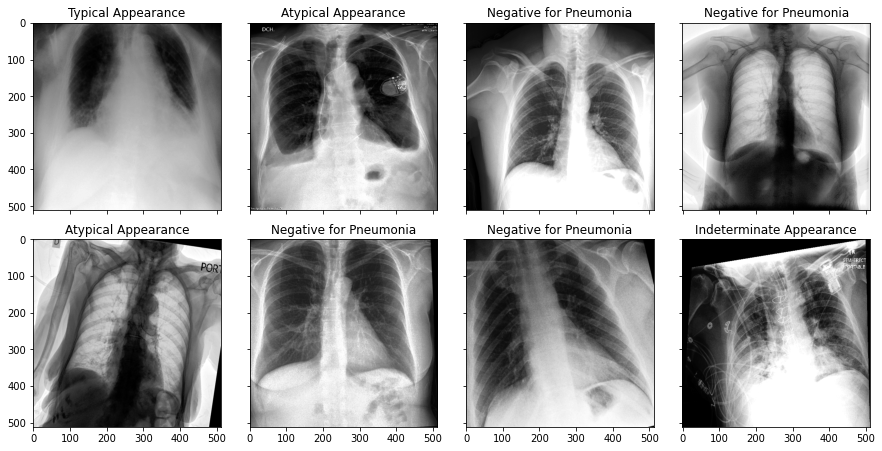

In [11]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np


dataiter = iter(train_dataloader)
sample = dataiter.next()
images = sample['image'] 
labels = sample['label']

fig = plt.figure(figsize=(15., 25.))
grid = ImageGrid(fig, 111, 
                 nrows_ncols=(2, 4),
                 axes_pad=.4,
                 )

labels_dict = {0: 'Negative for Pneumonia',  1: 'Typical Appearance',  2: 'Indeterminate Appearance',  3: 'Atypical Appearance'}

j = 0
for ax, im in zip(grid, images):
    im = im.numpy()
    im = np.transpose(im, (1,2,0))
    ax.imshow(im, cmap='gray')
    ax.set_title(labels_dict[labels[j].item()], fontsize=12)
    j += 1

plt.show()

### Dataloader for the preprocessed image data

In [12]:
class CovLungDataset(Dataset):
    def __init__(self, dir_path, labels_data, transforms=None):
        self.dir_path = dir_path
        self.labels_data = labels_data
        self.transforms = transforms

    def __len__(self):
        return len(self.labels_data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        image_dir = self.labels_data.iloc[idx]['id']
        img_label = self.labels_data.iloc[idx]['label']
        
        path_to_img = os.path.join(self.dir_path, f'{image_dir}.png')
        image = cv2.imread(path_to_img)
        
        if self.transforms:
            image = self.transforms(image=image)['image']
        
        return {'image': image, 'label': img_label}

In [13]:
transformed_dataset = CovLungDataset(dir_path='../input/siimcovid19-512-img-png-600-study-png/study',
                                     labels_data=train_study,
                                     transforms=transform,
                                     )


train_dataloader = DataLoader(transformed_dataset, batch_size=8, shuffle=False, num_workers=2)